<a href="https://colab.research.google.com/github/MalytkaDed/AZS/blob/master/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22LebedevPractica%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'plants-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5051137%2F8471020%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240523%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240523T161222Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9610dfbaef98eaa9e51b2886dd444587d9de589af101a20b62dd581df473b4e68337e787d14c53b5b4593bef8e9b976dbc752f902a62527f8e617f6b7a5f143e72c39dc4a3fb5cbc29b0532ebe39fc2ff139142c1350093a79e1dbf9fbf81fd21a86aba8f35e48af158dc512c0c402f36529e20def3d4c8b3a142739a16115d9bd42c5fc56e2802d042a737f63fb20fa3adba5320a19c8dfb9bcf270a40f9e64f0bdff5bff9d717cb98aae64c3582ed4959042e08bfda8648f4f7fdf4cea6eb245371d12ca8b9832a5297e4ca2fc2ecdcd183530628e1105ba0241dc87db6b7d309349cf2c76f3a00aa4da662727c244130bdf5307196a40463427eeefcdb16b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 281777433 bytes downloaded
Downloaded and uncompressed: plants-dataset
Data source import complete.


**Импортируемые библиотеки**

In [ ]:
import os
import numpy as np
from tensorflow.keras.models import Sequential
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import plotly.express as px
import scipy as sp
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

***Проверека распределения данных***

In [ ]:
class_names = ['flower', 'forest', 'house_plant']

n_flowers = len(os.listdir('/kaggle/input/plants-dataset/Var_6/flower'))

n_forests = len(os.listdir('/kaggle/input/plants-dataset/Var_6/forest'))

n_plants = len(os.listdir('/kaggle/input/plants-dataset/Var_6/house_plant'))

n_images = [n_flowers, n_forests, n_plants]

px.pie(names=class_names, values=n_images)

Сохраняем информацию о путях к изображениям и их метках классов в отдельный файл

In [ ]:
dataset_info = pd.DataFrame(columns=['Image_Path', 'Label'])

# Словарь с путями к каталогам изображений и соответствующими метками
classes = {
    '/kaggle/input/plants-dataset/Var_6/flower': 'Flower',
    '/kaggle/input/plants-dataset/Var_6/forest': 'Forest',
    '/kaggle/input/plants-dataset/Var_6/house_plant': 'House Plant'
}

for class_path in classes:
    for file_name in os.listdir(class_path):
        image_path = os.path.join(class_path, file_name)
        label = classes[class_path]
        dataset_info = pd.concat([dataset_info, pd.DataFrame({'Image_Path': [image_path], 'Label': [label]})], ignore_index=True)

dataset_info.to_csv('plants.csv', index=False)

Так как представленные данные классов несбалансированы, для исправления ситуации (то есть для достижения баланса между классами) увеличим количество примеров классе house_plant через технику oversampling

In [ ]:
file = pd.read_csv('plants.csv')
class_counts = file['Label'].value_counts()

# Вычисляем общее количество записей
total_records = len(file)

# Вычисляем текущее количество записей для house_plant
house_plant_count = class_counts['House Plant']

# Определяем, сколько раз нужно дублировать записи house_plant, чтобы достичь 50% от общего количества
desired_ratio = 0.33  # Желаемое соотношение для house_plant
current_ratio = house_plant_count / total_records
duplication_factor = desired_ratio / current_ratio

# Дублируем записи house_plant
house_plant_df = file[file['Label'] == 'House Plant']
duplicated_house_plant = pd.concat([house_plant_df]*int(duplication_factor), ignore_index=True)

# Объединяем оригинальный датасет с дублированными записями house_plant
balanced_dataset = pd.concat([file, duplicated_house_plant], ignore_index=True)

# Проверяем новый баланс классов
new_class_counts = balanced_dataset['Label'].value_counts()
print(new_class_counts)

# Сохраняем обновленный датасет
balanced_dataset.to_csv('balanced_plants.csv', index=False)


Label
Flower         2745
Forest         2626
House Plant    2405
Name: count, dtype: int64


In [ ]:
balanced_file = pd.read_csv('balanced_plants.csv')
balanced_file

,Image_Path,Label
0,/kaggle/input/plants-dataset/Var_6/flower/3494...,Flower
1,/kaggle/input/plants-dataset/Var_6/flower/1581...,Flower
2,/kaggle/input/plants-dataset/Var_6/flower/4980...,Flower
3,/kaggle/input/plants-dataset/Var_6/flower/8980...,Flower
4,/kaggle/input/plants-dataset/Var_6/flower/1492...,Flower
...,...,...
7771,/kaggle/input/plants-dataset/Var_6/house_plant...,House Plant
7772,/kaggle/input/plants-dataset/Var_6/house_plant...,House Plant
7773,/kaggle/input/plants-dataset/Var_6/house_plant...,House Plant
7774,/kaggle/input/plants-dataset/Var_6/house_plant...,House Plant


***Создаем генераторы для обучения и тестирования***

In [ ]:
train_file, test_file = train_test_split(balanced_file, test_size=0.2, random_state=42)

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range=45,
                                   vertical_flip=True,
                                   fill_mode='nearest')
# rescale=1./255 нормализует пиксели изображений, делая их значения находиться в диапазоне от 0 до 1.
# Другие параметры применяют случайные преобразования к изображениям для увеличения разнообразия данных
# и помощи в обучении модели.
train_datagen1 = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
train_generator = train_datagen.flow_from_dataframe(dataframe=train_file,
                                                    x_col="Image_Path",
                                                    y_col="Label",
                                                    target_size=(255, 255),
                                                    batch_size=32,
                                                    class_mode="categorical")
train_generator1 = train_datagen1.flow_from_dataframe(dataframe=train_file,
                                                    x_col="Image_Path",
                                                    y_col="Label",
                                                    target_size=(255, 255),
                                                    batch_size=32,
                                                    class_mode="categorical")


test_generator = test_datagen.flow_from_dataframe(dataframe=test_file,
                                                  x_col="Image_Path",
                                                  y_col="Label",
                                                  target_size=(255, 255),
                                                  batch_size=32,
                                                  class_mode="categorical")

Found 6220 validated image filenames belonging to 3 classes.
Found 6220 validated image filenames belonging to 3 classes.
Found 1556 validated image filenames belonging to 3 classes.


***Создание модели***

In [ ]:
inputs = Input(shape=(255, 255, 3))
x = Flatten()(inputs)
x = Dense(128, activation='relu')(x)
outputs = Dense(3, activation='softmax')(x)

basic_model = Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
basic_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = basic_model.fit(train_generator1, epochs=6, validation_data=test_generator)

Epoch 1/6
195/195 [==============================] - 22s 104ms/step - loss: 9.4383 - accuracy: 0.5966 - val_loss: 2.2360 - val_accuracy: 0.6883
Epoch 2/6
195/195 [==============================] - 19s 98ms/step - loss: 2.9155 - accuracy: 0.6613 - val_loss: 2.6133 - val_accuracy: 0.6819
Epoch 3/6
195/195 [==============================] - 21s 109ms/step - loss: 3.1490 - accuracy: 0.6743 - val_loss: 3.2374 - val_accuracy: 0.6362
Epoch 4/6
195/195 [==============================] - 21s 108ms/step - loss: 1.6830 - accuracy: 0.7352 - val_loss: 2.4464 - val_accuracy: 0.6298
Epoch 5/6
195/195 [==============================] - 22s 113ms/step - loss: 1.4413 - accuracy: 0.7545 - val_loss: 1.6790 - val_accuracy: 0.7641
Epoch 6/6
195/195 [==============================] - 19s 98ms/step - loss: 0.8899 - accuracy: 0.8064 - val_loss: 0.8678 - val_accuracy: 0.7892


# > ***Оценка производительности модели при использовании разных алгоритмов оптимизации***

In [ ]:
model_adam = Sequential()
model_adam.add(Conv2D(32, (3, 3), input_shape=(255, 255, 3), activation='relu'))
model_adam.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model_adam.add(MaxPooling2D(2, 2))
model_adam.add(Conv2D(64, (3, 3), activation='relu'))
model_adam.add(MaxPooling2D(2, 2))
model_adam.add(Conv2D(128, (3, 3), activation='relu'))
model_adam.add(MaxPooling2D(2, 2))
model_adam.add(Flatten())
model_adam.add(Dense(128, activation='relu'))
model_adam.add(Dropout(0.5))
model_adam.add(Dense(3, activation='softmax'))

model_adam.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_adam = model_adam.fit(train_generator, epochs=6, validation_data=test_generator)

Epoch 1/6
195/195 [==============================] - 123s 582ms/step - loss: 0.5930 - accuracy: 0.7640 - val_loss: 0.3904 - val_accuracy: 0.8470
Epoch 2/6
195/195 [==============================] - 112s 573ms/step - loss: 0.3865 - accuracy: 0.8601 - val_loss: 0.2489 - val_accuracy: 0.8985
Epoch 3/6
195/195 [==============================] - 112s 573ms/step - loss: 0.2853 - accuracy: 0.8974 - val_loss: 0.1890 - val_accuracy: 0.9351
Epoch 4/6
195/195 [==============================] - 111s 569ms/step - loss: 0.2781 - accuracy: 0.8998 - val_loss: 0.2699 - val_accuracy: 0.8946
Epoch 5/6
195/195 [==============================] - 112s 574ms/step - loss: 0.2870 - accuracy: 0.8947 - val_loss: 0.2107 - val_accuracy: 0.9165
Epoch 6/6
195/195 [==============================] - 113s 580ms/step - loss: 0.2159 - accuracy: 0.9219 - val_loss: 0.1383 - val_accuracy: 0.9479


In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(255, 255, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))


model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_SGD = model.fit(train_generator, epochs=6, validation_data=test_generator)

Epoch 1/6
195/195 [==============================] - 114s 571ms/step - loss: 0.8252 - accuracy: 0.6288 - val_loss: 0.5702 - val_accuracy: 0.7641
Epoch 2/6
195/195 [==============================] - 112s 575ms/step - loss: 0.5635 - accuracy: 0.7838 - val_loss: 0.4895 - val_accuracy: 0.8014
Epoch 3/6
195/195 [==============================] - 110s 566ms/step - loss: 0.5028 - accuracy: 0.8105 - val_loss: 0.4745 - val_accuracy: 0.8104
Epoch 4/6
195/195 [==============================] - 112s 572ms/step - loss: 0.4843 - accuracy: 0.8133 - val_loss: 0.4224 - val_accuracy: 0.8361
Epoch 5/6
195/195 [==============================] - 114s 585ms/step - loss: 0.4417 - accuracy: 0.8296 - val_loss: 0.3922 - val_accuracy: 0.8490
Epoch 6/6
195/195 [==============================] - 112s 572ms/step - loss: 0.4241 - accuracy: 0.8424 - val_loss: 0.4010 - val_accuracy: 0.8406


In [ ]:
model_rms = Sequential()
model_rms.add(Conv2D(32, (3, 3), input_shape=(255, 255, 3), activation='relu'))
model_rms.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model_rms.add(MaxPooling2D(2, 2))
model_rms.add(Conv2D(64, (3, 3), activation='relu'))
model_rms.add(MaxPooling2D(2, 2))
model_rms.add(Conv2D(128, (3, 3), activation='relu'))
model_rms.add(MaxPooling2D(2, 2))
model_rms.add(Flatten())
model_rms.add(Dense(128, activation='relu'))
model_rms.add(Dropout(0.5))
model_rms.add(Dense(3, activation='softmax'))


model_rms.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_RMS = model_rms.fit(train_generator, epochs=6, validation_data=test_generator)

Epoch 1/6
195/195 [==============================] - 113s 567ms/step - loss: 0.7562 - accuracy: 0.7191 - val_loss: 0.5290 - val_accuracy: 0.8091
Epoch 2/6
195/195 [==============================] - 112s 573ms/step - loss: 0.4819 - accuracy: 0.8256 - val_loss: 0.4659 - val_accuracy: 0.8278
Epoch 3/6
195/195 [==============================] - 111s 570ms/step - loss: 0.4068 - accuracy: 0.8561 - val_loss: 0.2709 - val_accuracy: 0.8991
Epoch 4/6
195/195 [==============================] - 111s 571ms/step - loss: 0.4698 - accuracy: 0.8735 - val_loss: 0.2194 - val_accuracy: 0.9190
Epoch 5/6
195/195 [==============================] - 112s 572ms/step - loss: 0.3292 - accuracy: 0.8931 - val_loss: 0.1462 - val_accuracy: 0.9441
Epoch 6/6
195/195 [==============================] - 113s 577ms/step - loss: 0.3361 - accuracy: 0.8981 - val_loss: 0.1753 - val_accuracy: 0.9287


***построение графиков***

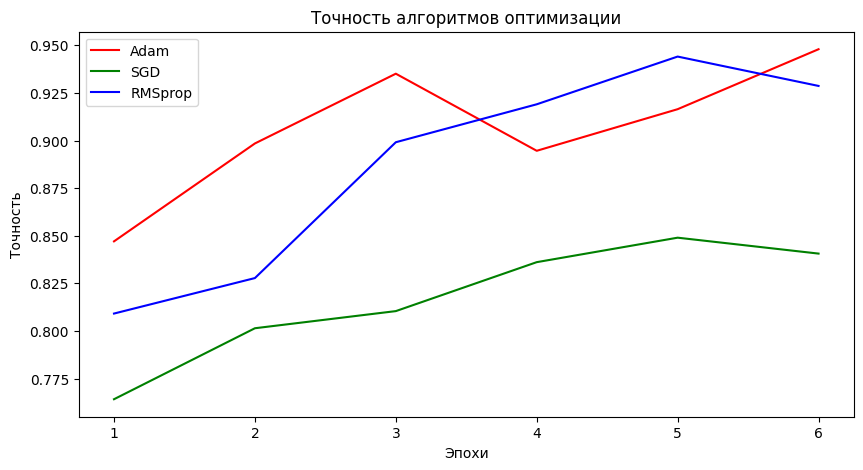

In [ ]:
import matplotlib.pyplot as plt

acc_Adam = history_adam.history['val_accuracy']
acc_SGD = history_SGD.history['val_accuracy']
acc_RMS = history_RMS.history['val_accuracy']

epochs = range(1, len(acc_Adam) + 1)

plt.figure(figsize=(10, 5))

plt.plot(epochs, acc_Adam, 'r', label='Adam')
plt.plot(epochs, acc_SGD, 'g', label='SGD')
plt.plot(epochs, acc_RMS, 'b', label='RMSprop')

plt.title('Точность алгоритмов оптимизации')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()

plt.show()